# Environment Setting

In [549]:
#google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [550]:
#google colab
!pip install sweetviz
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [551]:
# import libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#address missing value
from sklearn.impute import SimpleImputer

#data scaling
from sklearn.preprocessing import PowerTransformer,MinMaxScaler,QuantileTransformer,StandardScaler

#data preprocessing pipeline
from sklearn.pipeline import Pipeline

#modelling
from sklearn.metrics import roc_curve, auc, f1_score, roc_auc_score, classification_report, confusion_matrix, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [552]:
# Function to plot ROC curve
def plot_roc(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1, drop_intermediate = False)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.001, 1.001])
    plt.ylim([-0.001, 1.001])
    plt.xlabel('1-Specificity (False Negative Rate)')
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

# EDA

In [553]:
# reading data with pandas
# google colab path
data = pd.read_excel('/content/drive/MyDrive/Data-Science/bankruptcy_data.xlsx')

In [554]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92872 entries, 0 to 92871
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   EPS                 92867 non-null  float64
 1   Liquidity           92625 non-null  float64
 2   Profitability       92625 non-null  float64
 3   Productivity        92625 non-null  float64
 4   Leverage Ratio      92846 non-null  float64
 5   Asset Turnover      92625 non-null  float64
 6   Operational Margin  87315 non-null  float64
 7   Return on Equity    92864 non-null  float64
 8   Market Book Ratio   92815 non-null  float64
 9   Assets Growth       86171 non-null  float64
 10  Sales Growth        86171 non-null  float64
 11  Employee Growth     85862 non-null  float64
 12  BK                  92872 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 9.2 MB


**comments**
*   BK - is the target variable
*   All features are numerical values
*   All features have some missing values



In [555]:
data.head()

,EPS,Liquidity,Profitability,Productivity,Leverage Ratio,Asset Turnover,Operational Margin,Return on Equity,Market Book Ratio,Assets Growth,Sales Growth,Employee Growth,BK
0,1.58,0.36,0.18,0.13,1.33,1.77,0.07,0.15,2.22,NaN,NaN,NaN,0
1,1.41,0.36,0.19,0.12,1.31,1.59,0.07,0.13,2.41,0.126319,0.014278,0.040179,0
2,0.31,0.32,0.13,0.08,1.03,1.55,0.05,0.04,2.56,0.368077,0.327909,0.566524,0
3,0.71,0.28,0.14,0.08,0.80,1.39,0.06,0.05,5.28,-0.020809,-0.118904,-0.095890,0
4,0.75,0.41,0.13,0.08,0.20,1.30,0.06,0.04,8.68,0.233089,0.146807,0.053030,0


In [556]:
# check missing values
missing_total = data.isnull().sum().sort_values(ascending=False)
missing_perc = (data.isnull().sum() / data.isnull().count()).sort_values(ascending=False)
missing = pd.concat([missing_total ,missing_perc], axis=1, keys=['missing_total', 'missing_perc'])
missing

,missing_total,missing_perc
Employee Growth,7010,0.075480
Assets Growth,6701,0.072153
Sales Growth,6701,0.072153
Operational Margin,5557,0.059835
Liquidity,247,0.002660
Profitability,247,0.002660
Productivity,247,0.002660
Asset Turnover,247,0.002660
Market Book Ratio,57,0.000614
Leverage Ratio,26,0.000280


In [557]:
# check summary statistics
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
EPS,92867.0,-14.461355,2195.467288,-3.840000e+05,-0.140000,0.330000,1.530000,55339.00
Liquidity,92625.0,-2.631237,121.610921,-2.596852e+04,0.020000,0.190000,0.400000,1.00
Profitability,92625.0,-29.537274,677.230667,-7.968200e+04,-0.640000,0.070000,0.310000,140.58
Productivity,92625.0,-1.222870,35.885556,-5.093000e+03,-0.060000,0.060000,0.110000,1102.00
Leverage Ratio,92846.0,1.345316,253.038093,-7.811000e+03,0.000000,0.280000,0.820000,75970.38
Asset Turnover,92625.0,1.053613,2.115945,-3.159000e+01,0.390000,0.830000,1.390000,276.38
Operational Margin,87315.0,-7.915485,214.460079,-3.017570e+04,-0.030000,0.060000,0.140000,394.47
Return on Equity,92864.0,-2.112382,352.596902,-8.887514e+04,-0.080000,0.030000,0.070000,39500.00
Market Book Ratio,92815.0,358.506265,26063.637981,-3.151500e+06,11.200000,58.280000,240.140000,3455419.33
Assets Growth,86171.0,1.294075,73.769522,-1.000000e+00,-0.052596,0.051844,0.192062,14231.00


In [558]:
# Check for duplicates
data.duplicated().sum()

27

In [559]:
# Check for duplicates - list all duplicates
data[data.duplicated(keep=False)].transform(np.sort).head(20)

,EPS,Liquidity,Profitability,Productivity,Leverage Ratio,Asset Turnover,Operational Margin,Return on Equity,Market Book Ratio,Assets Growth,Sales Growth,Employee Growth,BK
7511,-3.02,-0.08,0.06,-0.04,0.65,0.28,-0.04,-0.14,9.86,-0.060779,-0.268154,-0.344557,0
20837,-3.02,-0.08,0.06,-0.04,0.65,0.28,-0.04,-0.14,9.86,-0.060779,-0.268154,-0.344557,0
20840,0.95,-0.07,0.07,0.06,0.65,0.29,0.13,0.05,11.92,-0.018581,-0.253067,-0.199961,0
20841,0.95,-0.07,0.07,0.06,0.65,0.29,0.13,0.05,11.92,-0.018581,-0.253067,-0.199961,0
20844,0.99,-0.07,0.07,0.08,0.66,0.31,0.13,0.06,12.19,-0.010286,-0.072410,-0.077668,0
21789,0.99,-0.07,0.07,0.08,0.66,0.31,0.13,0.06,12.19,-0.010286,-0.072410,-0.077668,0
24388,1.38,-0.05,0.09,0.09,0.67,0.33,0.14,0.07,13.55,-0.002466,-0.053691,-0.016834,0
26864,1.38,-0.05,0.09,0.09,0.67,0.33,0.14,0.07,13.55,-0.002466,-0.053691,-0.016834,0
26865,2.14,-0.05,0.09,0.09,0.69,0.39,0.14,0.08,15.75,0.009877,-0.034895,-0.011623,0
26866,2.14,-0.05,0.09,0.09,0.69,0.39,0.14,0.08,15.75,0.009877,-0.034895,-0.011623,0


In [560]:
# Remove duplicates
data = data.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)

In [561]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92845 entries, 0 to 92871
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   EPS                 92840 non-null  float64
 1   Liquidity           92598 non-null  float64
 2   Profitability       92598 non-null  float64
 3   Productivity        92598 non-null  float64
 4   Leverage Ratio      92819 non-null  float64
 5   Asset Turnover      92598 non-null  float64
 6   Operational Margin  87288 non-null  float64
 7   Return on Equity    92837 non-null  float64
 8   Market Book Ratio   92788 non-null  float64
 9   Assets Growth       86152 non-null  float64
 10  Sales Growth        86152 non-null  float64
 11  Employee Growth     85843 non-null  float64
 12  BK                  92845 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 9.9 MB


In [562]:
# Check for duplicates
data.duplicated().sum()

0

**Comments**: All duplicated records are removed

In [563]:
# check target balance - highly imbablanced data
target = data['BK'].value_counts()

print(data['BK'].value_counts())
print(' '* 30)
print('Financially stable: ', round(target[0]/len(data) * 100,2), '% of the dataset')
print('Bankrupt:           ', round(target[1]/len(data) * 100,2), '% of the dataset')

0    92287
1      558
Name: BK, dtype: int64
                              
Financially stable:  99.4 % of the dataset
Bankrupt:            0.6 % of the dataset


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


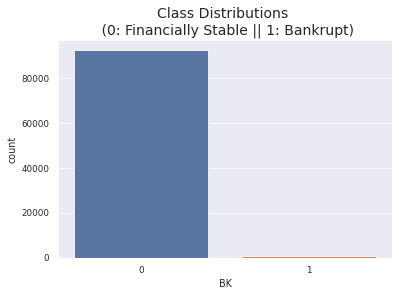

In [564]:
sns.set_theme(context = 'paper')

# plt.figure(figsize = (10,5))
sns.countplot(data.BK)
plt.title('Class Distributions \n (0: Financially Stable || 1: Bankrupt)', fontsize=14)
plt.show()

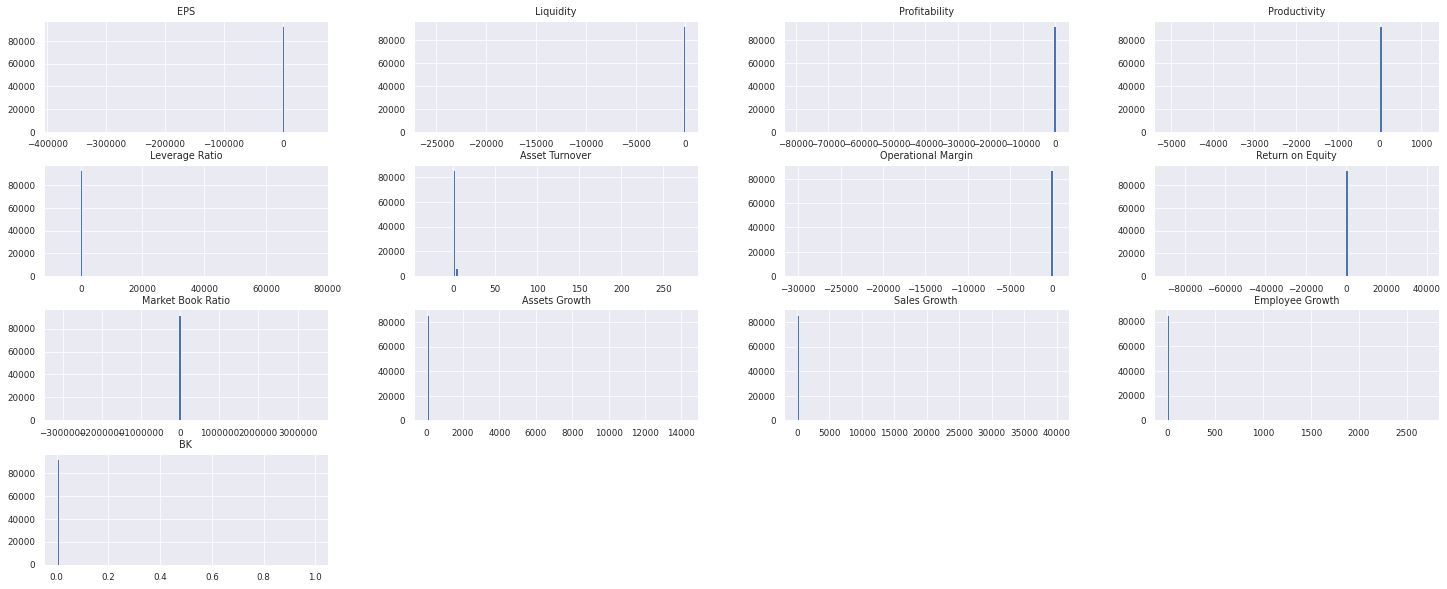

In [565]:
data.hist(figsize = (25,10), bins = 100)
plt.show()

In [566]:
import sweetviz as sv
report = sv.analyze(data, target_feat='BK')

#jupyter
# report.show_html('bankrupt.html')

#colab
report.show_html('/content/drive/MyDrive/Data-Science/bankrupt_data_raw.html')

                                             |          | [  0%]   00:00 -> (? left)

Report /content/drive/MyDrive/Data-Science/bankrupt_data_raw.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


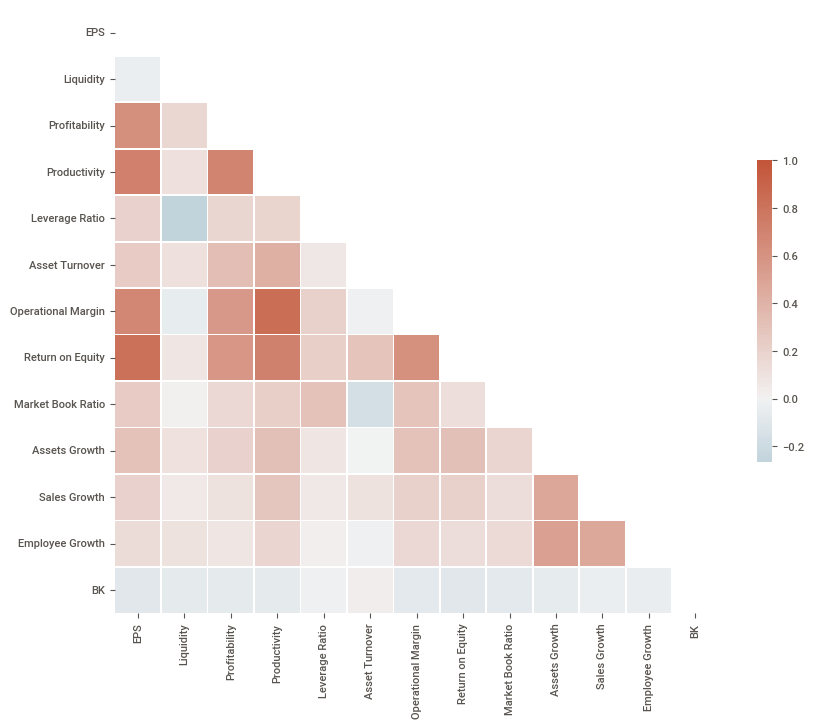

In [567]:
# Correlation Heatmap (Spearman)

f, ax = plt.subplots(figsize=(10,8))
mat = data.corr('spearman')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0,# annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

**Comments**
correlation heatmap shows EPS is highly correlated with: [ROE, Op. Margin, Productivity, Profitability] (their formulas share the same variable)

  *   EPS = (Net income - Preferred dividend) / common shares
  *   ROE = Net income / shareholder's equity
  *   Op. Margin = Operating income / Revenue

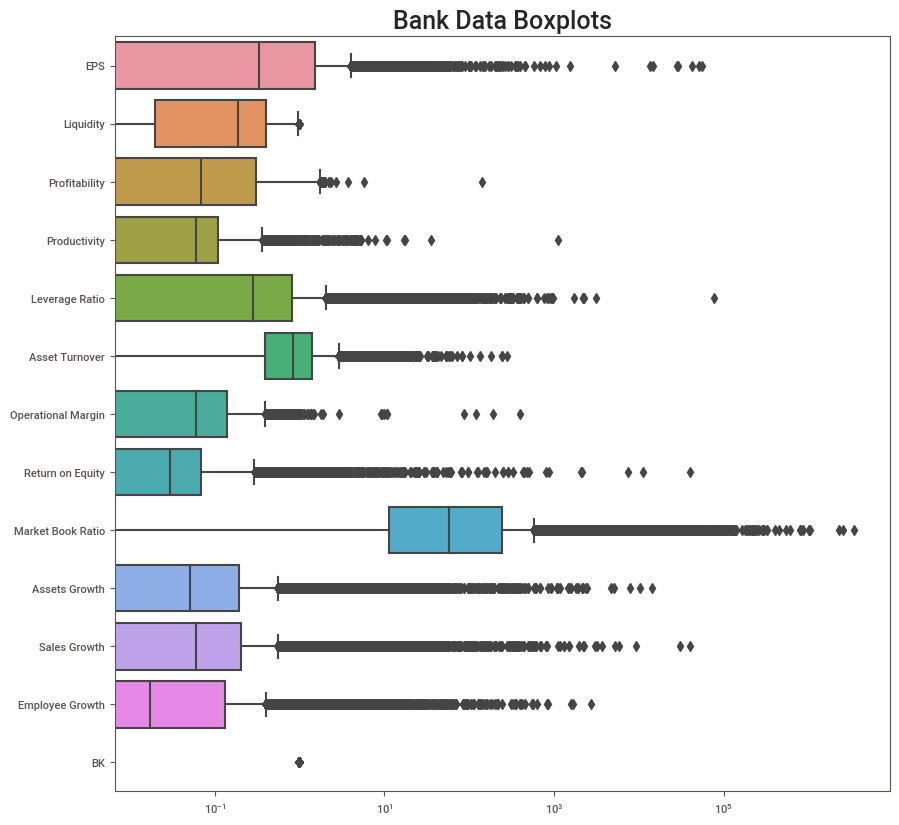

In [568]:
# Plotting Boxplots of the numerical features

plt.figure(figsize = (10,10))
ax =sns.boxplot(data = data, orient="h")
ax.set_title('Bank Data Boxplots', fontsize = 18)
ax.set(xscale="log")
plt.show()

In [569]:
data.pivot_table(index='BK')

,Asset Turnover,Assets Growth,EPS,Employee Growth,Leverage Ratio,Liquidity,Market Book Ratio,Operational Margin,Productivity,Profitability,Return on Equity,Sales Growth
BK,,,,,,,,,,,,
0,1.05126,1.302652,-13.236567,0.341823,1.348358,-2.643312,360.368025,-7.947752,-1.227019,-29.675381,-1.934606,1.903211
1,1.46649,0.020853,-219.338251,0.618409,0.862939,-0.767256,60.481545,-3.146859,-0.602488,-8.193908,-31.832970,1.487656


# Train Test Data Split

Data is split into training and testing sets before any pre-processing steps, data preprocessing pipeline is only exposed to training data set. 



In [570]:
X = data.drop(['BK'], axis=1)
y = data['BK']

In [571]:
# check X variable
X.head()

,EPS,Liquidity,Profitability,Productivity,Leverage Ratio,Asset Turnover,Operational Margin,Return on Equity,Market Book Ratio,Assets Growth,Sales Growth,Employee Growth
0,1.58,0.36,0.18,0.13,1.33,1.77,0.07,0.15,2.22,NaN,NaN,NaN
1,1.41,0.36,0.19,0.12,1.31,1.59,0.07,0.13,2.41,0.126319,0.014278,0.040179
2,0.31,0.32,0.13,0.08,1.03,1.55,0.05,0.04,2.56,0.368077,0.327909,0.566524
3,0.71,0.28,0.14,0.08,0.80,1.39,0.06,0.05,5.28,-0.020809,-0.118904,-0.095890
4,0.75,0.41,0.13,0.08,0.20,1.30,0.06,0.04,8.68,0.233089,0.146807,0.053030


In [572]:
# check y variable
y.head()

0    0
1    0
2    0
3    0
4    0
Name: BK, dtype: int64

In [573]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((64991, 12), (64991,), (27854, 12), (27854,))

In [574]:
y_train.value_counts()

0    64595
1      396
Name: BK, dtype: int64

In [575]:
y_test.value_counts()

0    27692
1      162
Name: BK, dtype: int64

# Building data_pipeline for preprocessing

The following data transformation are required as identified in the EDA section above: 
1.   Remove outlier - cap the values within (0.5 - 0.95) quartile 
2.   Address missing values - missing value % are low, replace missing value with mean
3.   Scale all numeric data - explore different scaling methods




In [576]:
# Making a customized column transformer to handle outliers

# https://nbviewer.jupyter.org/github/queirozfcom/python-sandbox/blob/master/python3/notebooks/pipelines-custom-steps/main.ipynb
# https://www.section.io/engineering-education/custom-transformer/

class CustomTransformer():
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self

In [577]:
# Function to Address Outliters 
def cap_data(df):
    for col in df.iloc[:,0:12]:
        print("capping the ",col)
        if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int64')):
            percentiles = df[col].quantile([0.05,0.95]).values
            df[col][df[col] <= percentiles[0]] = percentiles[0]
            df[col][df[col] >= percentiles[1]] = percentiles[1]
        else:
            df[col]=df[col]
    return df

In [578]:
# numeric features
numeric_features = X_train.select_dtypes(include='number').columns.tolist()
print(numeric_features)

['EPS', 'Liquidity', 'Profitability', 'Productivity', 'Leverage Ratio', 'Asset Turnover', 'Operational Margin', 'Return on Equity', 'Market Book Ratio', 'Assets Growth', 'Sales Growth', 'Employee Growth']


In [579]:
# build pipeline for numeric features
numeric_pipeline = Pipeline(steps=[
    ('remove_outlier', CustomTransformer(cap_data)),
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', QuantileTransformer(random_state=0))
])


    # ('scale', MinMaxScaler())                           #LG Baseline AUC 0.8645154013371067
    # ('scale', QuantileTransformer(random_state=0))      #LG Baseline AUC 0.8665507977523481
    # ('scale', StandardScaler())                         #LG Baseline AUC 0.8655610748212702

In [580]:
# https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html

from sklearn.compose import ColumnTransformer
data_pipeline = ColumnTransformer(transformers=[  ('numeric', numeric_pipeline, numeric_features) ])

In [581]:
# fit entire data pipeline
data_pipeline.fit_transform(X_train)

capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth
capping the  Employee Growth


array([[0.28528529, 0.35985986, 0.29179179, ..., 0.35812946, 0.27851238,
        0.71411226],
       [0.86086086, 0.27977978, 1.        , ..., 0.24160966, 0.23611023,
        0.19652997],
       [0.32932933, 0.05905906, 0.0953954 , ..., 0.92846425, 0.31181181,
        0.        ],
       ...,
       [0.48848849, 0.32782783, 0.56506507, ..., 0.91417543, 0.64208049,
        0.94474756],
       [0.57307307, 0.74474474, 0.69019019, ..., 0.90223074, 0.92029105,
        0.92942998],
       [1.        , 0.27977978, 0.49049049, ..., 0.85372195, 0.36097872,
        0.76176176]])

In [582]:
# we can now use data_pipeline to transform X_train and X_test
X_train_transformed = data_pipeline.transform(X_train)
X_test_transformed = data_pipeline.transform(X_test)

capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth
capping the  Employee Growth
capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth
capping the  Employee Growth


In [583]:
col_names = X_train.columns.to_list()
X_train_processed = pd.DataFrame(X_train_transformed, columns=col_names)
data_transformed = pd.merge(X_train_processed, y_train, left_index=True, right_index=True)

In [584]:
# summary statistics - make sure outliter is fixed
data_transformed.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
EPS,45460.0,0.500078,0.292709,0.0,0.251070,0.501502,0.749750,1.0
Liquidity,45460.0,0.499752,0.292723,0.0,0.244745,0.505506,0.744745,1.0
Profitability,45460.0,0.499556,0.292793,0.0,0.249150,0.500501,0.748749,1.0
Productivity,45460.0,0.500616,0.292844,0.0,0.253253,0.512513,0.736236,1.0
Leverage Ratio,45460.0,0.500786,0.292281,0.0,0.174675,0.499499,0.751251,1.0
Asset Turnover,45460.0,0.501463,0.293892,0.0,0.255255,0.504505,0.751752,1.0
Operational Margin,45460.0,0.499712,0.291847,0.0,0.251752,0.516016,0.748749,1.0
Return on Equity,45460.0,0.500077,0.293119,0.0,0.250751,0.497998,0.767768,1.0
Market Book Ratio,45460.0,0.500099,0.293388,0.0,0.249054,0.500758,0.750515,1.0
Assets Growth,45460.0,0.500343,0.292217,0.0,0.250299,0.500290,0.750025,1.0


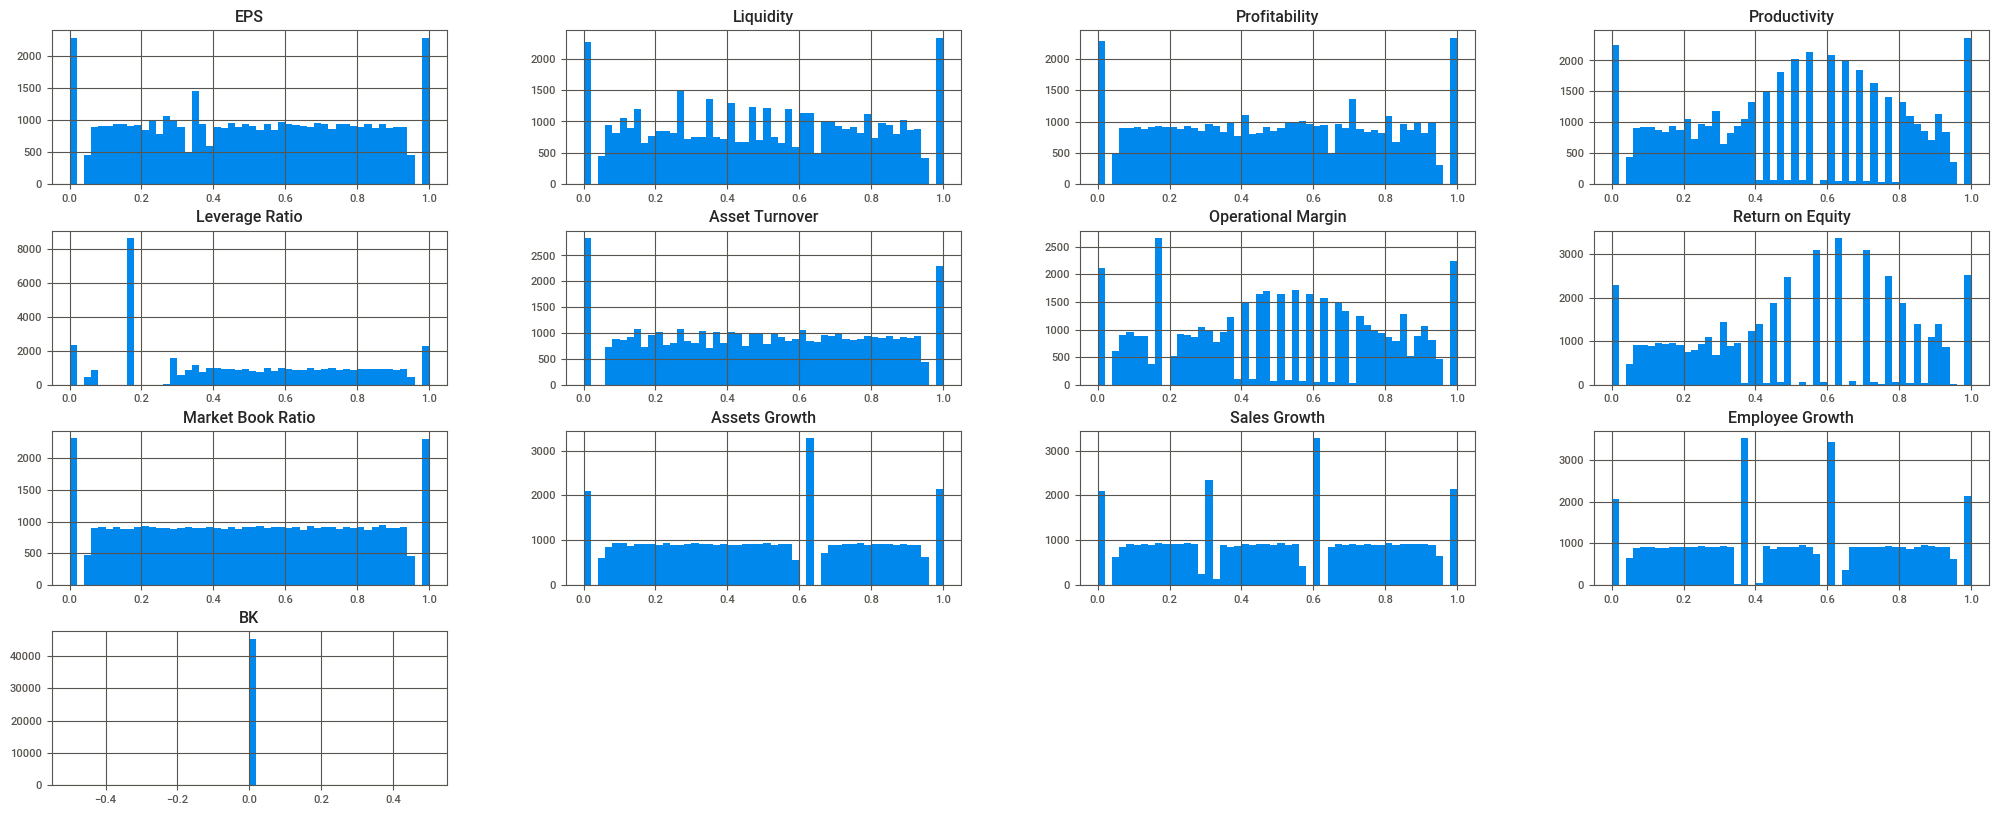

In [585]:
data_transformed.hist(figsize = (25,10), bins = 50)
plt.show()

In [587]:
#Plot transformed data
report = sv.analyze(data_transformed, target_feat='BK')
report.show_html('/content/drive/MyDrive/Data-Science/bankrupt_data_processed.html')

                                             |          | [  0%]   00:00 -> (? left)

Report /content/drive/MyDrive/Data-Science/bankrupt_data_processed.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# Set Confusion Matrix Threshold


In [443]:
class_threshold = 0.5

# Model Training: Logistic Regression baseline model

Note: this baseline model is unable to predict positive scenarios. Confusion matrix: false negative = 162 means the model is unable to identify any bankrupt company correctly. (testing set only contains 162 bankrupt companies) --> need to address imbalance data

In [517]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(random_state=123, max_iter=100)

In [518]:
lr_pipeline = Pipeline(steps=[
                    ('preprocess', data_pipeline),
                    ('model', lr_model)])

In [519]:
# fit pipeline with model
lr_pipeline.fit(X_train, y_train)

capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth
capping the  Employee Growth


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('remove_outlier',
                                                                   <__main__.CustomTransformer object at 0x7f3efde9bd00>),
                                                                  ('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   QuantileTransformer(random_state=0))]),
                                                  ['EPS', 'Liquidity',
                                                   'Profitability',
                                                   'Productivity',
                                                   'Leverage Ratio',
                                                   'Asset Turnover',
           

In [520]:
# predict probability on X_test
y_pred_proba = lr_pipeline.predict_proba(X_test)
y_pred_proba

capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth
capping the  Employee Growth


array([[9.99865151e-01, 1.34848537e-04],
       [9.99618009e-01, 3.81990873e-04],
       [9.87513381e-01, 1.24866186e-02],
       ...,
       [9.99879787e-01, 1.20212606e-04],
       [9.99674072e-01, 3.25928307e-04],
       [9.65064947e-01, 3.49350534e-02]])

In [521]:
# AUC on test set
roc_auc_score(y_test, y_pred_proba[:,1])

0.8665507977523481

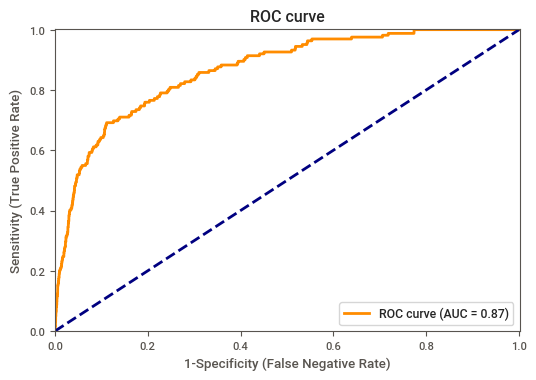

In [522]:
plot_roc(y_test, y_pred_proba[:,1])

In [523]:
# confusion matrix
y_pred = np.where(y_pred_proba[:,1] > class_threshold, 1, 0) # applying the threshold rule to classify

print(confusion_matrix(y_test, y_pred))

[[27692     0]
 [  162     0]]


In [524]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(27692, 0, 162, 0)

In [525]:
# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     27692
           1       0.00      0.00      0.00       162

    accuracy                           0.99     27854
   macro avg       0.50      0.50      0.50     27854
weighted avg       0.99      0.99      0.99     27854



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [453]:
# Weighted F1 score
f1_score(y_test, y_pred, average='weighted')

0.9912844200701049

# Model Training: Logistic Regression - Random Under Sampler, Hyperparameter tunning

https://medium.com/@kocur4d/hyper-parameter-tuning-with-pipelines-5310aff069d6

unable to predict positive scenarios (confusion matrix) after hyperparameter tuning

In [527]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
# X_train_resampled, y_train_resampled = rus.fit_resample(X_train_transformed, y_train)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

In [528]:
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns.to_list())
y_train_resampled = pd.DataFrame(y_train_resampled, columns=['BK'])

In [529]:
X_train_resampled.shape, y_train_resampled.shape

((792, 12), (792, 1))

In [530]:
y_train_resampled.value_counts()

BK
0     396
1     396
dtype: int64

In [531]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(random_state=123)

In [532]:
lr_pipeline = Pipeline(steps=[
                    ('preprocess', data_pipeline),
                    ('model', lr_model)])

# fit pipeline with model
lr_pipeline.fit(X_train_resampled, y_train_resampled)

# predictions from pipeline
y_pred = lr_pipeline.predict(X_test)
y_pred

capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth
capping the  Employee Growth
capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth
capping the  

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (792). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Employee Growth


array([0, 0, 0, ..., 0, 0, 1])

In [533]:
# predict probability on X_test
y_pred_proba = lr_pipeline.predict_proba(X_test)
y_pred_proba

capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth
capping the  Employee Growth


array([[0.9472865 , 0.0527135 ],
       [0.84530817, 0.15469183],
       [0.52700587, 0.47299413],
       ...,
       [0.95643697, 0.04356303],
       [0.94236634, 0.05763366],
       [0.23520981, 0.76479019]])

In [534]:
# AUC on test set
roc_auc_score(y_test, y_pred_proba[:,1])

0.8701242771010214

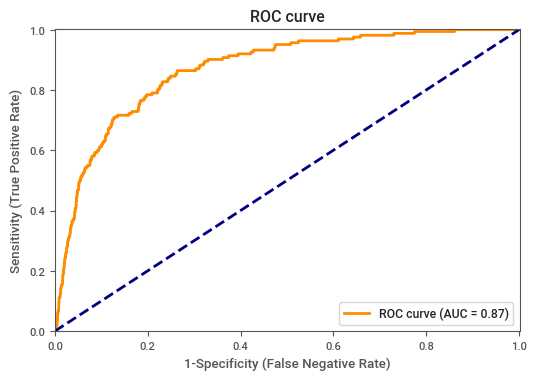

In [535]:
plot_roc(y_test, y_pred_proba[:,1])

In [536]:
# confusion matrix
y_pred = np.where(y_pred_proba[:,1] > class_threshold, 1, 0) # applying the threshold rule to classify

print(confusion_matrix(y_test, y_pred))

[[22630  5062]
 [   39   123]]


In [537]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(22630, 5062, 39, 123)

In [538]:
# Create dictionary with candidate learning algorithms and their hyperparameters
grid_param = [
                {'model__class_weight': [None, 'balanced'],
                 'model__solver': ['newton-cg', 'lbfgs', 'liblinear'],
                 'model__C': np.logspace(0, 4, 10),
                 'model__penalty': ['l2']
                 }
            ]
# grid_lr = {
# 'cls__class_weight': [None, 'balanced'],
# 'cls__C': [0, .001, .01, .1, 1]
# }

In [539]:
# Hyper-parameter tuning ("optimization") using the function GridSearchCV for maximizing AUC
score_func = make_scorer(roc_auc_score, greater_is_better=True)

# create a gridsearch of the pipeline, the fit the best model
gridsearch = GridSearchCV(lr_pipeline, grid_param, cv=5, verbose=0, n_jobs=-1, scoring = score_func) # Fit grid search

In [540]:
gridsearch_model = gridsearch.fit(X_train,y_train)

capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth
capping the  Employee Growth


In [541]:
print("Best Score: ", gridsearch_model.best_score_)
print("Best Params: ", gridsearch_model.best_params_)

Best Score:  0.8245391036751875
Best Params:  {'model__C': 1.0, 'model__class_weight': 'balanced', 'model__penalty': 'l2', 'model__solver': 'liblinear'}


In [542]:
y_pred_proba = gridsearch_model.predict_proba(X_test)
y_pred_proba

capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth
capping the  Employee Growth


array([[0.98417702, 0.01582298],
       [0.92302669, 0.07697331],
       [0.51258827, 0.48741173],
       ...,
       [0.98747511, 0.01252489],
       [0.92388806, 0.07611194],
       [0.1895597 , 0.8104403 ]])

In [543]:
roc_auc_score(y_test, y_pred_proba[:,1])

0.8728977304137399

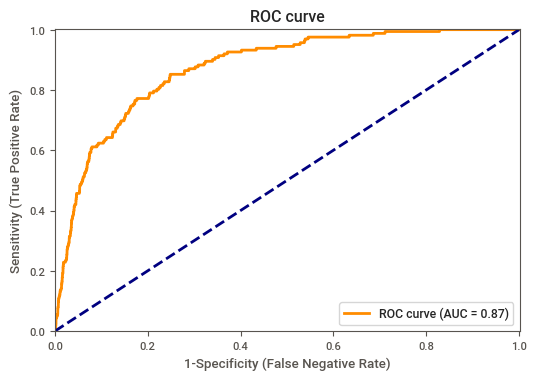

In [544]:
plot_roc(y_test, y_pred_proba[:,1])

In [545]:
# confusion matrix
y_pred = np.where(y_pred_proba[:,1] > class_threshold, 1, 0) # applying the threshold rule to classify

print(confusion_matrix(y_test, y_pred))

[[22269  5423]
 [   37   125]]


In [546]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(22269, 5423, 37, 125)

In [547]:
# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89     27692
           1       0.02      0.77      0.04       162

    accuracy                           0.80     27854
   macro avg       0.51      0.79      0.47     27854
weighted avg       0.99      0.80      0.89     27854



In [475]:
# Weighted F1 score
f1_score(y_test, y_pred, average='weighted')

0.885869370866668

# Model: Random Forest, balanced

In [476]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=123, class_weight='balanced')

In [477]:
rf_pipeline = Pipeline(steps=[
                    ('preprocess', data_pipeline),
                    ('model', rf_model)])

In [478]:
# fit pipeline with model
rf_pipeline.fit(X_train, y_train)

capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth
capping the  Employee Growth


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('remove_outlier',
                                                                   <__main__.CustomTransformer object at 0x7f3efde9bd00>),
                                                                  ('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   QuantileTransformer(random_state=0))]),
                                                  ['EPS', 'Liquidity',
                                                   'Profitability',
                                                   'Productivity',
                                                   'Leverage Ratio',
                                                   'Asset Turnover',
           

In [479]:
# predictions from pipeline
y_pred = rf_pipeline.predict(X_test)
y_pred_proba = rf_pipeline.predict_proba(X_test)

capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth
capping the  Employee Growth
capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth
capping the  Employee Growth


In [480]:
roc_auc_score(y_test, y_pred_proba[:,1])

0.8516731890299468

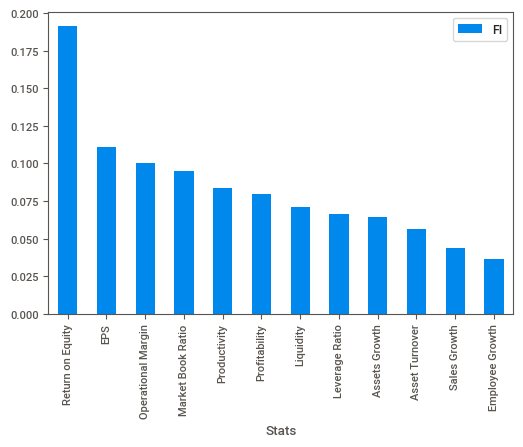

In [481]:
# plot feature_importances_
d = {'Stats':X_train.columns,'FI':rf_pipeline[1].feature_importances_}
df = pd.DataFrame(d)
df = df.sort_values(by='FI', ascending=False)
ax = df.plot.bar(x='Stats', y='FI', rot=90)

In [482]:
# Create dictionary with candidate learning algorithms and their hyperparameters
grid_param = [
                {
                 "model__n_estimators": [10, 100],
                 "model__max_depth":[5,10,15],
                 "model__max_features":[0.8, "auto"]
                 }
            ]

In [483]:
# Hyper-parameter tuning ("optimization") using the function GridSearchCV for maximizing AUC
score_func = make_scorer(roc_auc_score, greater_is_better=True)

# create a gridsearch of the pipeline, the fit the best model
randsearch = RandomizedSearchCV(rf_pipeline, grid_param, cv=5, verbose=0, n_jobs=-1, scoring = score_func) # Fit grid search

In [484]:
randsearch_model = randsearch.fit(X_train,y_train)

capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth
capping the  Employee Growth


In [485]:
print("Best Score: ", randsearch_model.best_score_)
print("Best Params: ", randsearch_model.best_params_)

Best Score:  0.8227945335640472
Best Params:  {'model__n_estimators': 100, 'model__max_features': 'auto', 'model__max_depth': 5}


In [486]:
randsearch_model.best_estimator_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('remove_outlier',
                                                                   <__main__.CustomTransformer object at 0x7f3ed8436d30>),
                                                                  ('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   QuantileTransformer(random_state=0))]),
                                                  ['EPS', 'Liquidity',
                                                   'Profitability',
                                                   'Productivity',
                                                   'Leverage Ratio',
                                                   'Asset Turnover',
           

In [487]:
# predict probability on X_test
y_pred_proba = randsearch_model.predict_proba(X_test)
y_pred_proba

capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth
capping the  Employee Growth


array([[0.97683677, 0.02316323],
       [0.87872018, 0.12127982],
       [0.73364706, 0.26635294],
       ...,
       [0.96572963, 0.03427037],
       [0.79579568, 0.20420432],
       [0.21901695, 0.78098305]])

In [488]:
roc_auc_score(y_test, y_pred_proba[:,1])

0.8897010635509118

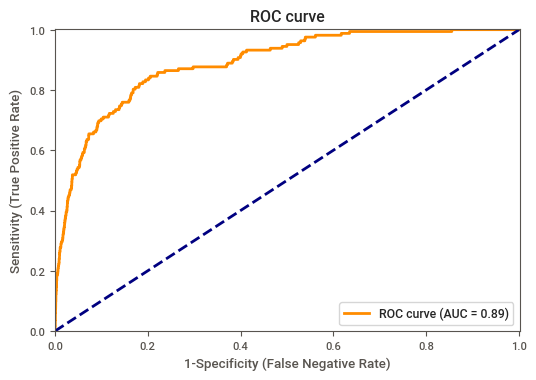

In [489]:
plot_roc(y_test, y_pred_proba[:,1])

In [490]:
# confusion matrix
y_pred = np.where(y_pred_proba[:,1] > class_threshold, 1, 0) # applying the threshold rule to classify

print(confusion_matrix(y_test, y_pred))

[[24707  2985]
 [   47   115]]


In [491]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(24707, 2985, 47, 115)

In [492]:
# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94     27692
           1       0.04      0.71      0.07       162

    accuracy                           0.89     27854
   macro avg       0.52      0.80      0.51     27854
weighted avg       0.99      0.89      0.94     27854



In [493]:
# Weighted F1 score
f1_score(y_test, y_pred, average='weighted')

0.9371184332791092

In [494]:
# for plotting the one of the tree from RF model
randsearch_model.best_estimator_[1].estimators_[1]

DecisionTreeClassifier(max_depth=5, max_features='auto', random_state=914636141)

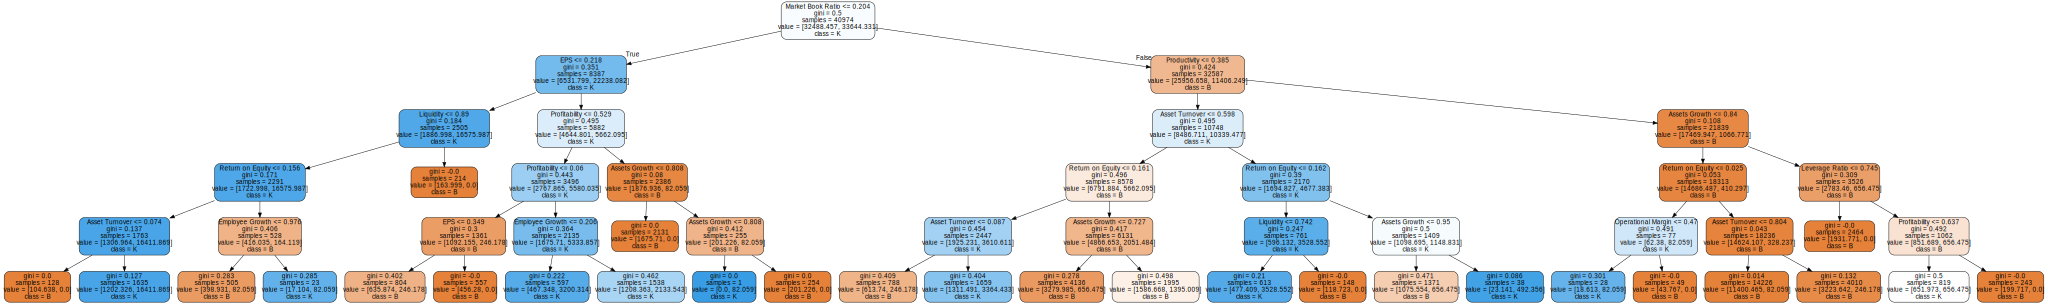

In [495]:
# for plotting the one of the tree from RF model
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(
                           randsearch_model.best_estimator_[1].estimators_[1],
                           feature_names = X_train.columns.to_list(),
                            class_names = 'BK',
                           filled=True, impurity=True, 
                           rounded=True)

graph = graphviz.Source(dot_data, format='png')
graph

# Model: Naive Bayes, under sampling (NB model does not have class_weight)

In [496]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

In [497]:
X_train_resampled.shape, y_train_resampled.shape

((792, 12), (792,))

In [498]:
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns.to_list())

In [499]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()

In [500]:
nb_pipeline = Pipeline(steps=[
                    ('preprocess', data_pipeline),
                    ('model', nb_model)])

In [501]:
# fit pipeline with model
nb_pipeline.fit(X_train_resampled, y_train_resampled)

capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth
capping the  Employee Growth


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (792). n_quantiles is set to n_samples.
  warnings.warn(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('remove_outlier',
                                                                   <__main__.CustomTransformer object at 0x7f3efde9bd00>),
                                                                  ('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   QuantileTransformer(random_state=0))]),
                                                  ['EPS', 'Liquidity',
                                                   'Profitability',
                                                   'Productivity',
                                                   'Leverage Ratio',
                                                   'Asset Turnover',
           

In [502]:
# predictions from pipeline
y_pred_proba = nb_pipeline.predict_proba(X_test)

capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth
capping the  Employee Growth


In [503]:
roc_auc_score(y_test, y_pred_proba[:,1])

0.8424994159743064

In [504]:
# Create dictionary with candidate learning algorithms and their hyperparameters
grid_param = [
                {
                 "model__var_smoothing": np.logspace(0,-9, num=100)
                 }
            ]

In [505]:
# Hyper-parameter tuning ("optimization") using the function GridSearchCV for maximizing AUC
score_func = make_scorer(roc_auc_score, greater_is_better=True)

# create a gridsearch of the pipeline, the fit the best model
randsearch = RandomizedSearchCV(nb_pipeline, grid_param, cv=5, verbose=0, n_jobs=-1, scoring = score_func) # Fit grid search

In [506]:
randsearch_model = randsearch.fit(X_train,y_train)

capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth
capping the  Employee Growth


In [507]:
print("Best Score: ", randsearch_model.best_score_)
print("Best Params: ", randsearch_model.best_params_)

Best Score:  0.7584915248466344
Best Params:  {'model__var_smoothing': 0.004328761281083057}


In [508]:
# predict probability on X_test
y_pred_proba = randsearch_model.predict_proba(X_test)
y_pred_proba

capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth
capping the  Employee Growth


array([[1.00000000e+00, 1.01266486e-13],
       [1.00000000e+00, 1.95616098e-10],
       [9.76310575e-01, 2.36894247e-02],
       ...,
       [1.00000000e+00, 1.74443551e-14],
       [9.99933332e-01, 6.66682460e-05],
       [3.64968084e-01, 6.35031916e-01]])

In [509]:
roc_auc_score(y_test, y_pred_proba[:,1])

0.8473216403364701

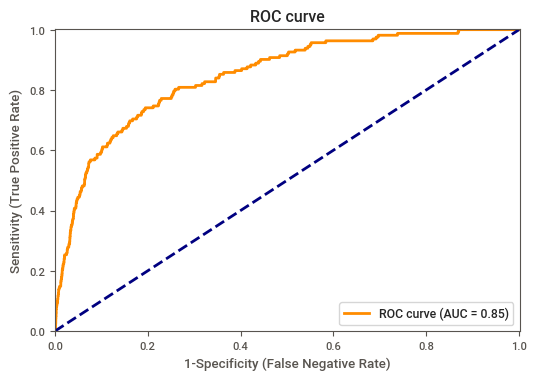

In [510]:
plot_roc(y_test, y_pred_proba[:,1])

In [511]:
# confusion matrix
y_pred = np.where(y_pred_proba[:,1] > class_threshold, 1, 0) # applying the threshold rule to classify

print(confusion_matrix(y_test, y_pred))

[[25307  2385]
 [   69    93]]


In [512]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(25307, 2385, 69, 93)

In [513]:
# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95     27692
           1       0.04      0.57      0.07       162

    accuracy                           0.91     27854
   macro avg       0.52      0.74      0.51     27854
weighted avg       0.99      0.91      0.95     27854



In [514]:
# Weighted F1 score
f1_score(y_test, y_pred, average='weighted')

0.9486201176018613

# Next Steps
*  Classification Threshold selection requires further analysis
*  other sampling method (over sampling) can be explored to address imbalance data
*  Feature Engineering + Feature Selection can be explored
*  Other algorithms - SVM, GBT can be explored



